In [103]:
import japanize_matplotlib  # noqa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path
from typing import Optional
from matplotlib.axes import Axes

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["font.size"] = 25
plt.rcParams["xtick.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 25
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 30

RESULT_PATH = Path("../output/result.csv")
METRICS_MAP = {
    # "exec_time": "CPU time (s)",
    "exec_time_rate": "実行時間の比率",
    # "user_util": "User utility",
    # "mean_max_envy": "Mean max envy",
    # "pct_item_util_better": "Items better off (%)",
    # "pct_item_util_worse": "Items worse off (%)",
    "exec_time": "実行時間 (秒)",
    "user_util": "利用者満足度",
    "mean_max_envy": "平均最大羨望",
    "pct_item_util_better": "10%改善割合",
    "pct_item_util_worse": "10%改悪割合",
}
METRICS = list(METRICS_MAP.keys())
METHOD_MAP = {
    # "greedy": "MaxRele",
    # "expo_fair": "ExpFair",
    # "nsw": "NSW",
    # "greedy_nsw": "NSW(Greedy)",
    # "ot_nsw": "NSW(Algo1)",
    # "pgd_nsw": "NSW (射影勾配法) ",
    "greedy": "関連度順",
    "expo_fair": "閲覧公平",
    "nsw": "NSW",
    "greedy_nsw": "NSW(貪欲)",
    "ot_nsw": "NSW(Algo1)",
    "pgd_nsw": "NSW (射影勾配法) ",
}
METHOD_TO_COLOR = {
    "MaxRele": "#E24A33",
    "関連度順": "#E24A33",
    "ExpFair": "#FBC15E",
    "ExpFair(Mosek)": "#FBC15E",
    "ExpFair(SCS)": "#FBC15E",
    "閲覧公平": "#FBC15E",
    "閲覧公平(Mosek)": "#FBC15E",
    "NSW(Greedy)": "#777777",
    "NSW(貪欲)": "#777777",
    "NSW (既存) ": "#988ED5",
    "NSW(Mosek)": "#988ED5",
    "NSW(SCS)": "#988ED5",
    "NSW(Algo1)": "#348ABD",
    "NSW(Algo1+GPU)": "#348ABD",
    "NSW (射影勾配法) ": "#8EBA42",
}
METHOD_TO_LINESTYLE = {
    "MaxRele": "-",
    "関連度順": "-",
    "ExpFair": "-",
    "閲覧公平": "-",
    "ExpFair(Mosek)": "-",
    "閲覧公平(Mosek)": "-",
    "閲覧公平 (SCS) ": "-",
    "NSW(Greedy)": "-",
    "NSW(貪欲)": "-",
    "NSW (既存) ": "-",
    "NSW(Mosek)": "-",
    "NSW (SCS) ": "-",
    "NSW(Algo1)": "--",
    "NSW(Algo1+GPU)": "-",
    "NSW (射影勾配法) ": "-",
}

OUTPUT_DIR = Path("../output/fig")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [104]:
def load_result(
    path: Path,
    exp_names: list[str],
    on: list[str] = ["seed"],
    ideal_method: str = "NSW(Mosek)",
    ignore_methods: list[str] = ["pg_ot"],
    ignore_solver: list[str] = ["SCS"],
    consider_solver: bool = True,
    consider_device: bool = False,
    dropna: bool = True,
) -> pd.DataFrame:
    result = pd.read_csv(path)

    # Filter by experiment name
    result = result.query(f"exp_name in {exp_names}")
    # # Filter by optimizer params method
    result = result.query(f"optimizer_name not in {ignore_methods}").reset_index(drop=True)
    # Filter by solver
    if consider_solver:
        result = result.query(f"optimizer_params_solver not in {ignore_solver}").reset_index(
            drop=True
        )
    # Filter by device
    if not consider_device:
        result = result.query("optimizer_params_device != 'cpu'").reset_index(drop=True)

    # Initialize metrics
    result["exec_time_rate"] = np.nan

    # rename method
    result["method"] = result["optimizer_name"].map(METHOD_MAP)
    if consider_solver:
        # solverがMOSEKだったらMosekに変更
        result["optimizer_params_solver"] = result["optimizer_params_solver"].replace(
            {"MOSEK": "Mosek"}
        )
        result["optimizer_params_solver"] = result["optimizer_params_solver"].apply(
            lambda x: f"({x})" if x == x else ""
        )
        result["method"] += result["optimizer_params_solver"]
    if consider_device:
        # optimizer_params_deviceがcudaだったらmethodはNSW(Algo1+GPU)に変更
        result["method"] = result["method"].mask(
            result["optimizer_params_device"].fillna("") == "cuda", "NSW(Algo1+GPU)"
        )

    #
    ideal = result.query("method == @ideal_method").reset_index(drop=True)
    ideal = ideal.drop_duplicates(subset=on)
    result = pd.merge(
        result[on + ["method"] + METRICS],
        ideal[on + METRICS],
        on=on,
        suffixes=("", "_nsw"),
        how="left",
    )

    # Calculate exec_time_rate
    result["exec_time_rate"] = result["exec_time"] / result["exec_time_nsw"]

    # drop na
    num_na: pd.DataFrame = result[METRICS].isna().sum(axis=0).to_frame()
    num_na.columns = ["number_of_nan"]
    display(num_na)
    if dropna:
        result = result.dropna(subset=METRICS)

    return result.reset_index(drop=True)

In [105]:
base_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_base"],
    on=["generator_params_n_query", "generator_params_n_doc", "generator_K", "seed"],
    consider_solver=True,
    consider_device=False,
    dropna=False,
    ignore_methods=["pgd_nsw"],
)

,number_of_nan
exec_time_rate,0
exec_time,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


# ベースサイズの実験

In [106]:
def plot_metrics_bar(
    base_size_result: pd.DataFrame,
    metrics: list[str] = [
        "user_util",
        "mean_max_envy",
        "pct_item_util_better",
        "pct_item_util_worse",
    ],
):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10 * 2, 10 * 2 + 2), tight_layout=True)
    axes = np.ravel(axes)

    unique_method = base_size_result["method"].unique().tolist()
    order = [method for method in METHOD_TO_COLOR.keys() if method in unique_method]
    pallete = [METHOD_TO_COLOR[method] for method in order]

    for i, metric in enumerate(metrics):
        ax = sns.barplot(
            base_size_result,
            x="method",
            y=metric,
            ax=axes[i],
            legend=True,
            order=order,
            palette=pallete,
            hue="method",
            hue_order=order,
            errorbar=None,
        )
        ax.set_title(METRICS_MAP[metric], fontsize=52)
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.tick_params(axis="both", labelsize=35)
        ax.set_xticks([])

        if metric in ["pct_item_util_better", "pct_item_util_worse"]:
            ax.set_ylim(0, 105)

        # 棒グラフの上に値を追加
        for j, p in enumerate(ax.patches):
            height = p.get_height()
            if (height == 0) & (p.get_x() == 0):  # monky patch
                continue
            ax.text(
                p.get_x() + p.get_width() / 2,
                height,
                f"{height:.2f}",
                ha="center",
                va="bottom",
                fontsize=35,
            )

        handles, legend = ax.get_legend_handles_labels()
        ax.get_legend().remove()

    fig.legend(
        handles,
        legend,
        fontsize=42,
        bbox_to_anchor=(0.5, 1.15),
        ncol=3,
        loc="upper center",
    )
    return fig

## データの読み込み

In [107]:
# 人工データ
base_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_base"],
    on=["generator_params_n_query", "generator_params_n_doc", "generator_K", "seed"],
    consider_solver=True,
    ignore_methods=["pgd_nsw"],
)
display(base_size_result.head(5))

# 実データ
base_size_real_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_base_real"],
    on=["generator_params_n_query", "generator_params_n_doc", "generator_K", "seed"],
    consider_solver=True,
    ignore_methods=["pgd_nsw"],
)

,number_of_nan
exec_time_rate,0
exec_time,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_params_n_query,generator_params_n_doc,generator_K,seed,method,exec_time_rate,exec_time,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_rate_nsw,exec_time_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1000.0,500,10,4,NSW(貪欲),0.000064,0.323854,2.079538,0.000269,93.8,0.8,NaN,5093.972370,2.158096,0.000038,97.0,0.0
1,1000.0,500,10,3,NSW(貪欲),0.000071,0.321901,2.110971,0.000119,93.2,0.4,NaN,4549.397303,2.184864,0.000041,97.4,0.0
2,1000.0,500,10,2,NSW(貪欲),0.000083,0.333427,2.061374,0.000097,94.0,0.4,NaN,4020.717532,2.143812,0.000037,97.0,0.2
3,1000.0,500,10,1,NSW(貪欲),0.000093,0.322148,2.062914,0.000118,93.8,0.4,NaN,3467.584497,2.145651,0.000039,97.8,0.0
4,1000.0,500,10,0,NSW(貪欲),0.000111,0.324240,2.073492,0.000139,94.0,0.8,NaN,2912.228539,2.155045,0.000040,97.2,0.0


,number_of_nan
exec_time_rate,0
exec_time,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


### 人工データ

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


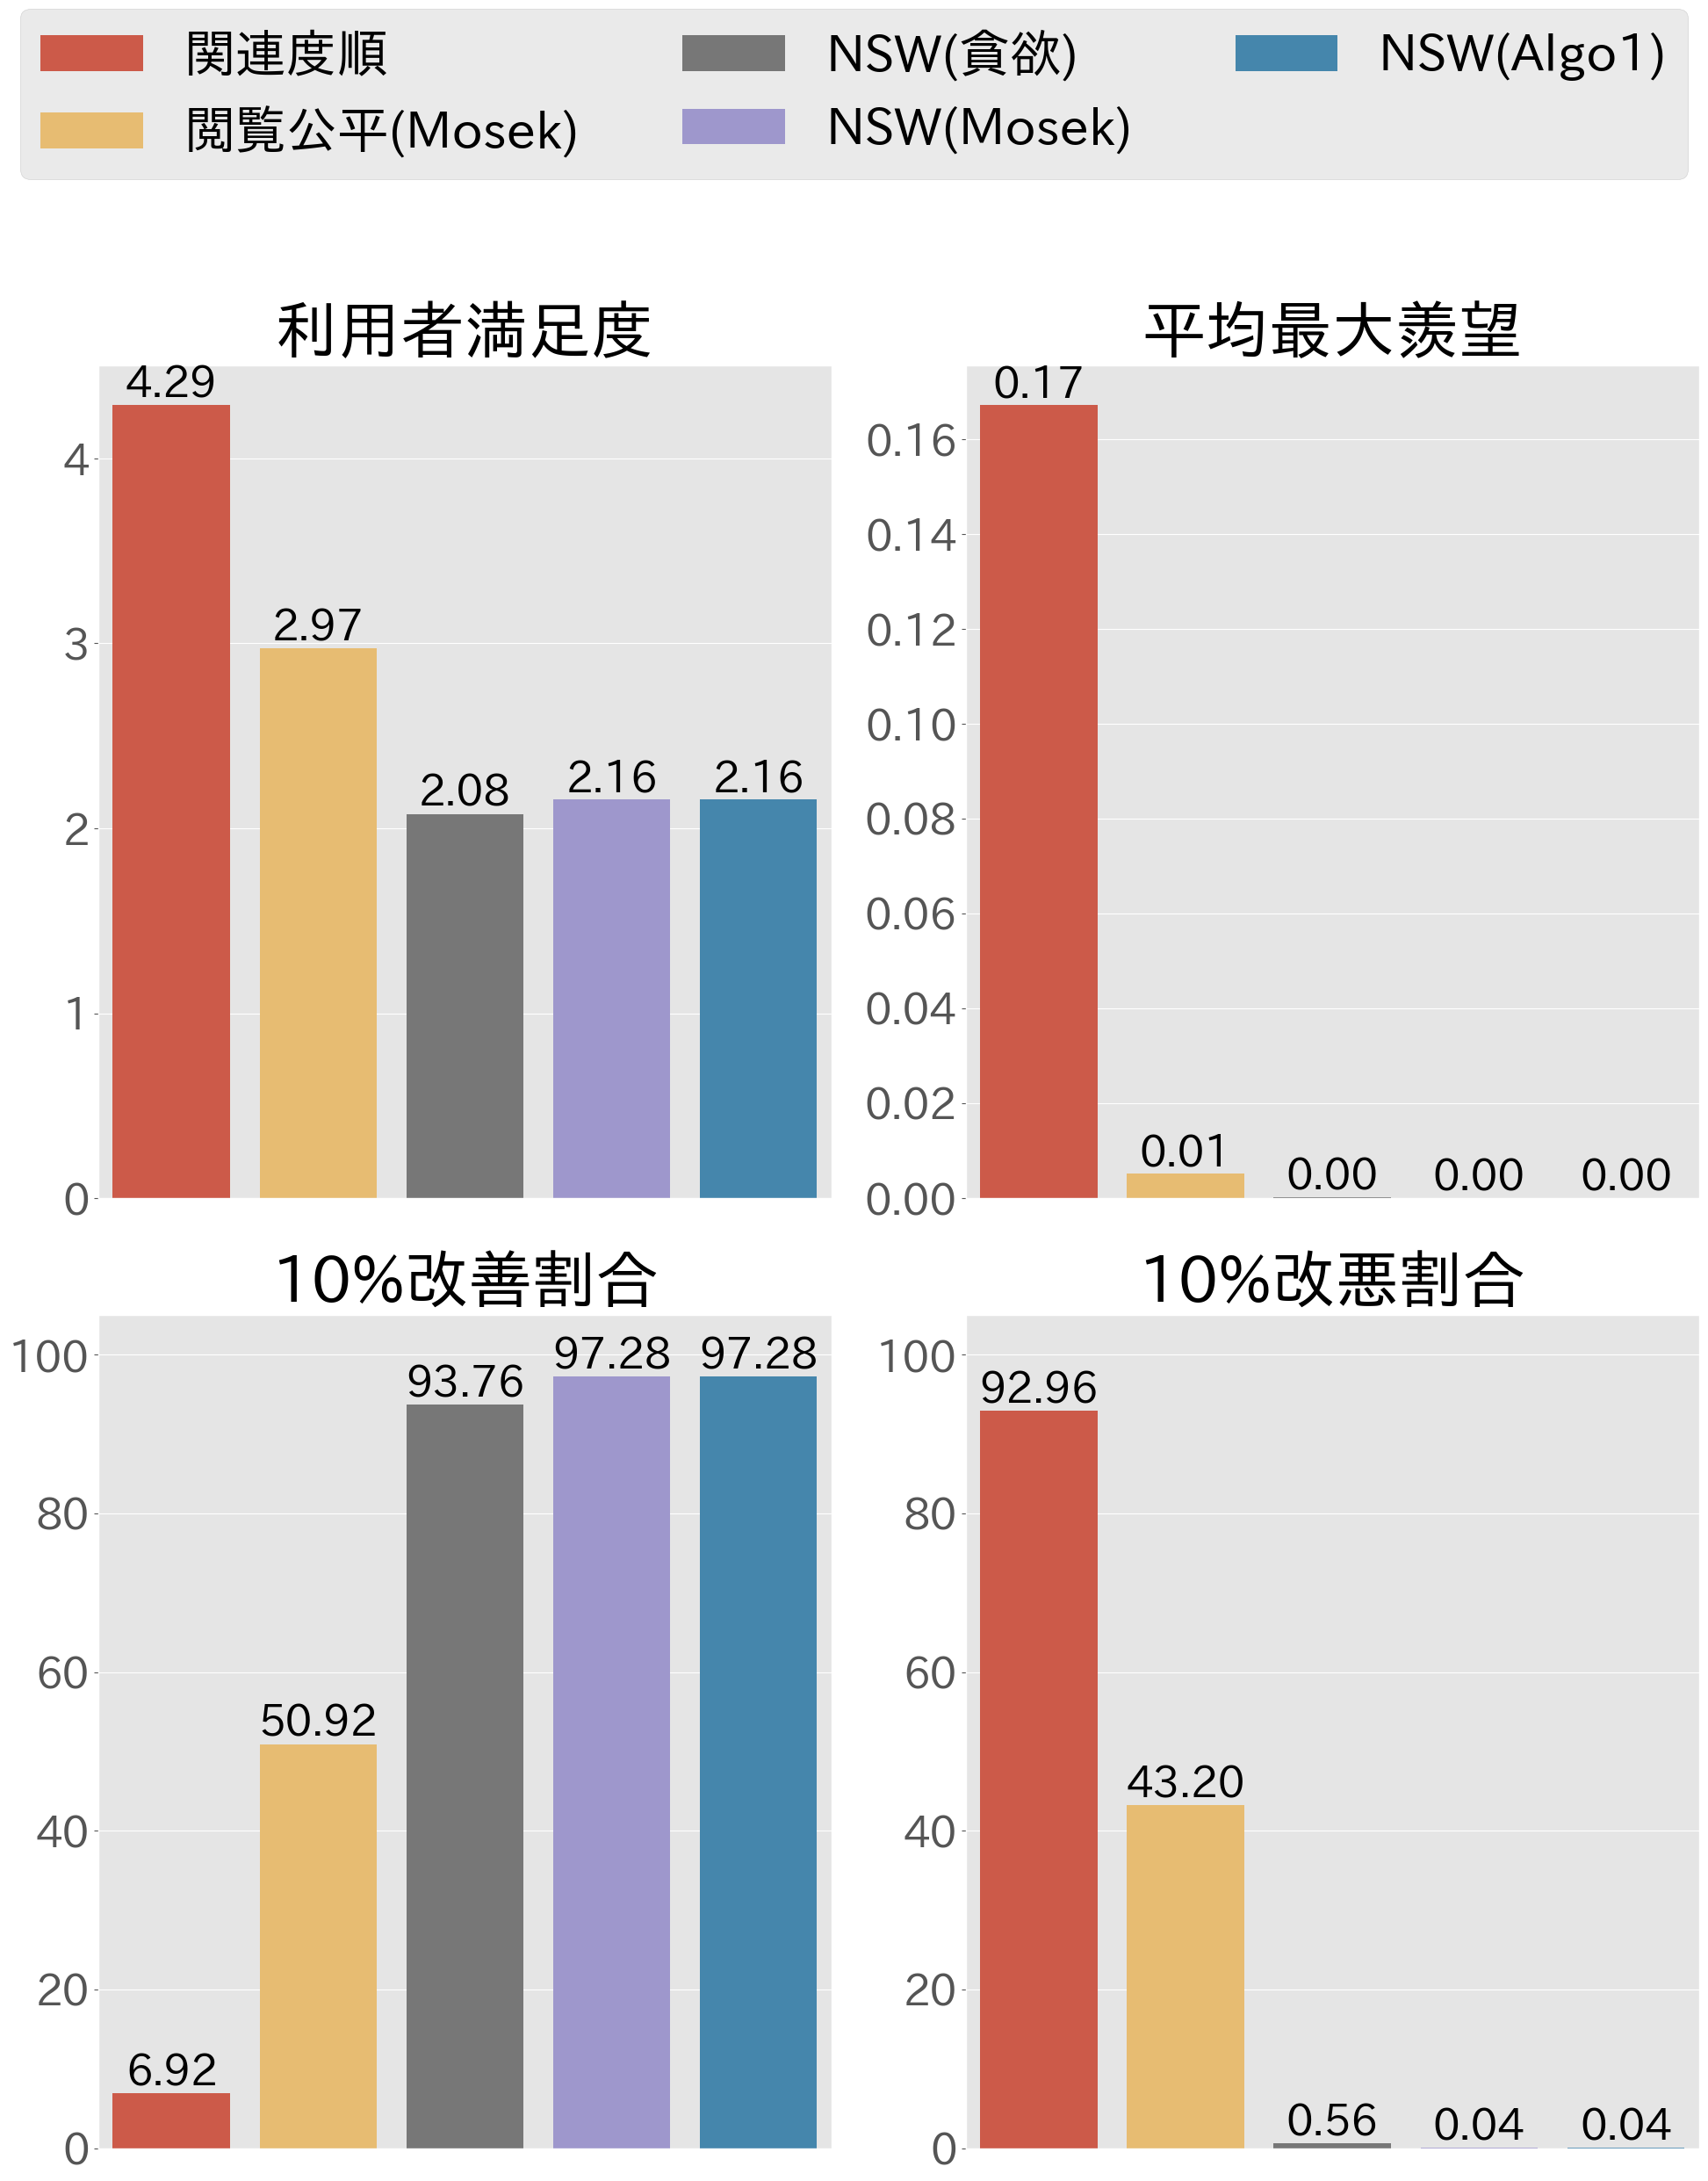

In [108]:
fig = plot_metrics_bar(base_size_result)
fig.savefig(OUTPUT_DIR / "artificial_data_eval.eps", bbox_inches="tight")

### 実データ

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


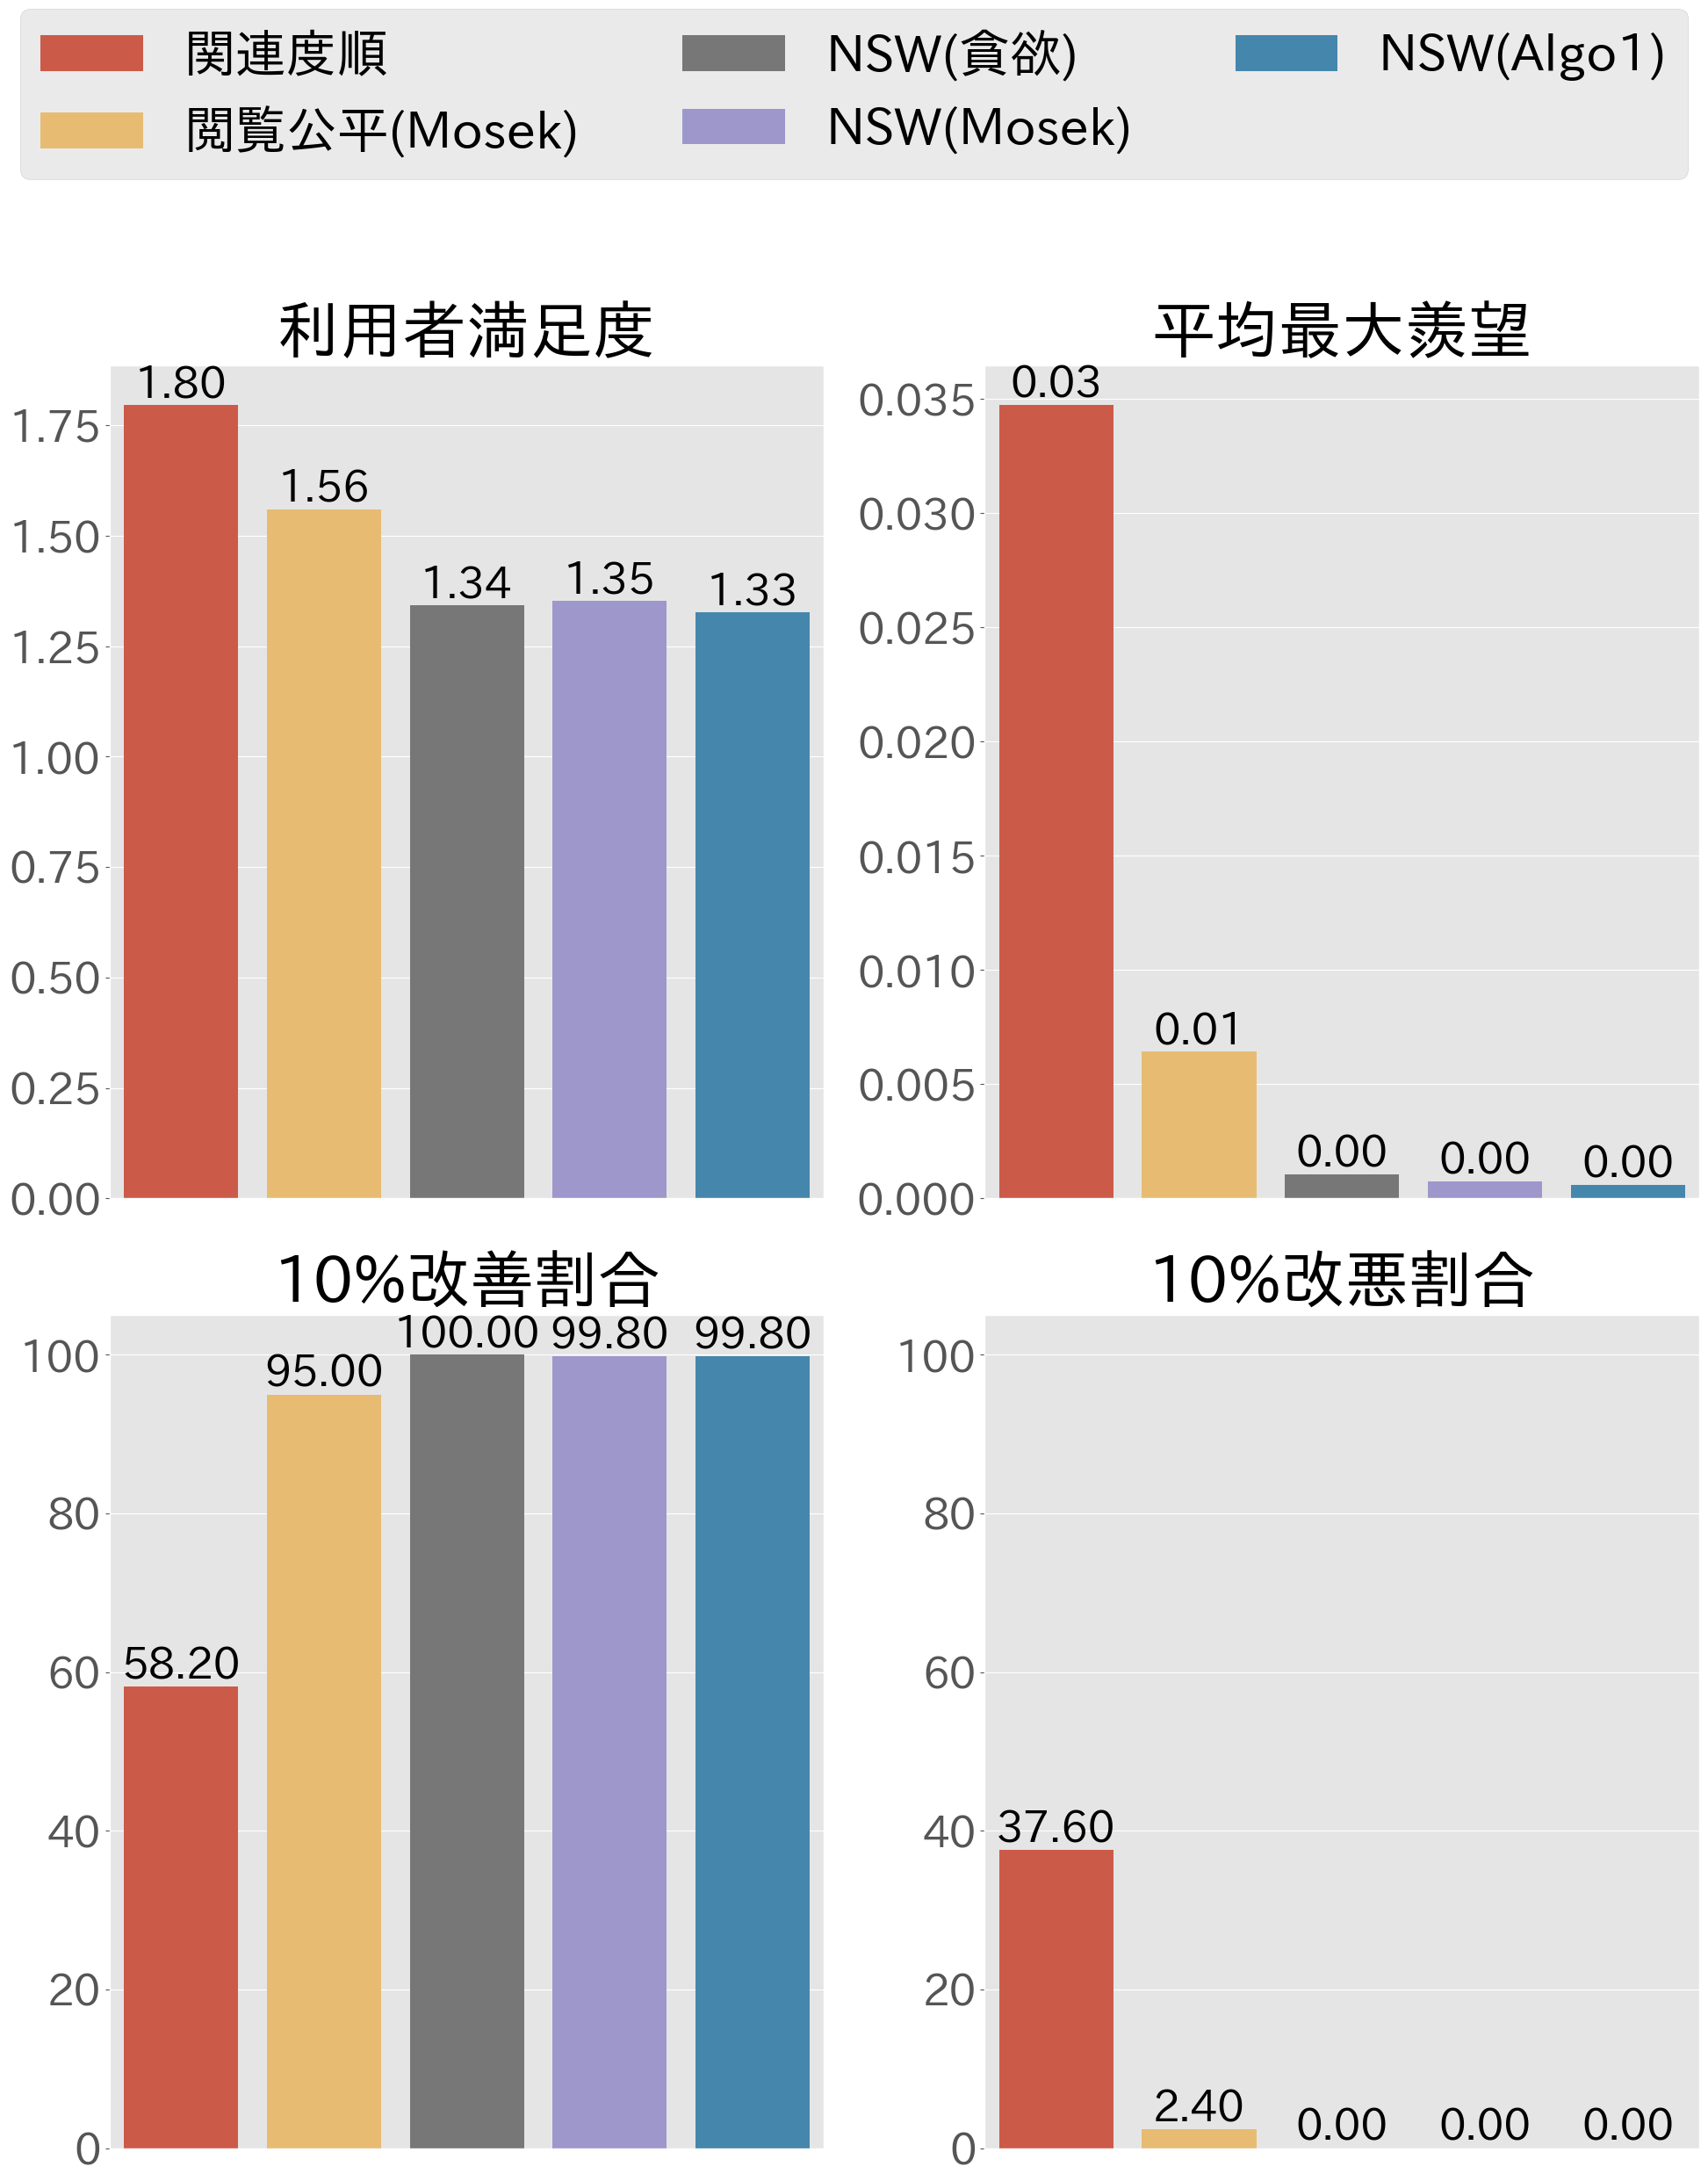

In [109]:
plot_metrics_bar(base_size_real_result)
fig.savefig(OUTPUT_DIR / "real_data_eval.eps", bbox_inches="tight")

# アイテム数、利用者数、アイテムのクラスタ数、利用者のクラスタ数を変化させたときの実験

## 公平性、満足度

In [110]:
def plot_fairness_and_user_utils(
    result: pd.DataFrame,
    x: str,
    xlabel: str,
    legend: bool = True,
    errorbar: Optional[tuple[str, float]] = None,
    metrics: list[str] = [
        "user_util",
        "mean_max_envy",
        "pct_item_util_better",
        "pct_item_util_worse",
    ],
):
    fig, axes = plt.subplots(2, 2, figsize=(10 * 2, 10 * 2 + 2), tight_layout=True)
    axes: list[Axes] = np.ravel(axes).tolist()

    unique_method = result["method"].unique().tolist()
    order = [method for method in METHOD_TO_COLOR.keys() if method in unique_method]

    for i, metric in enumerate(metrics):
        ax = axes[i]
        for j, method in enumerate(order):
            color = METHOD_TO_COLOR[method]
            sns.lineplot(
                result.query("method == @method"),
                x=x,
                y=metric,
                ax=ax,
                marker="o",
                markersize=15,
                markers=True,
                linewidth=8,
                linestyle=METHOD_TO_LINESTYLE[method],
                legend=True,
                color=color,
                hue="method",
                palette=[color],
                errorbar=errorbar,
            )

            if metric in [
                "pct_item_util_better",
                "pct_item_util_worse",
            ]:
                ax.set_ylim(-5, 105)
            elif metric == "exec_time":
                ax.set_yscale("log")
                ax.set_ylim(bottom=5e-1, top=5e3)

        ax.set_title(METRICS_MAP[metric], fontsize=52)
        ax.set_ylabel("")
        ax.set_xlabel(xlabel, fontsize=42)
        ax.tick_params(axis="both", labelsize=35)

        handles, _ = ax.get_legend_handles_labels()
        ax.get_legend().remove()

    if legend:
        fig.legend(
            handles,
            order,
            fontsize=42,
            bbox_to_anchor=(0.5, 1.15),
            ncol=3,
            loc="upper center",
        )

    return fig

In [111]:
# アイテム数を変化させた場合
varying_item_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_item"],
    on=["generator_params_n_doc", "seed"],
    ignore_methods=["pgd_nsw"],
    consider_solver=True,
)
display(varying_item_size_result.head(5))

# 利用者数を変化させた場合
varying_user_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_user"],
    on=["generator_params_n_query", "seed"],
    ignore_methods=["pgd_nsw"],
    consider_solver=True,
)
display(varying_user_size_result.head(5))

# クラスタ数を変化させた場合
varying_cluster_size_result = pd.read_csv(RESULT_PATH)
varying_cluster_size_result = varying_cluster_size_result.query(
    "exp_name == 'exp_cluster'"
).reset_index(drop=True)
varying_cluster_size_result["n_params"] = (
    100
    * (
        varying_cluster_size_result["optimizer_params_n_doc_cluster"]
        * varying_cluster_size_result["optimizer_params_n_query_cluster"]
    )
    / (
        varying_cluster_size_result["generator_params_n_doc"]
        * varying_cluster_size_result["generator_params_n_query"]
    )
)
varying_cluster_size_result["method"] = "NSW(Algo1+GPU)"
display(varying_cluster_size_result.head(5))

,number_of_nan
exec_time_rate,15
exec_time,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_params_n_doc,seed,method,exec_time_rate,exec_time,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_rate_nsw,exec_time_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1600,4,NSW(貪欲),0.000111,0.122731,2.560889,0.002382,48.8750,42.5625,NaN,1108.811406,2.146756,0.000014,97.7500,0.250
1,1600,1,NSW(貪欲),0.000104,0.124772,2.584863,0.002368,48.9375,44.8125,NaN,1205.428054,2.158890,0.000014,97.6250,0.250
2,1600,0,NSW(貪欲),0.000108,0.123640,2.564897,0.002377,49.0000,43.0625,NaN,1147.260273,2.148788,0.000015,97.5625,0.000
3,800,4,NSW(貪欲),0.000411,0.101498,2.167701,0.001275,58.1250,0.8750,NaN,247.035245,2.159054,0.000027,97.5000,0.375
4,800,3,NSW(貪欲),0.000416,0.095537,2.170258,0.001292,58.0000,1.0000,NaN,229.724557,2.167068,0.000029,97.5000,0.125


,number_of_nan
exec_time_rate,0
exec_time,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_params_n_query,seed,method,exec_time_rate,exec_time,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_rate_nsw,exec_time_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1600.0,0,NSW(貪欲),0.001543,0.454402,1.988474,0.000131,30.0,1.2,NaN,294.552099,2.139198,0.000074,97.2,0.0
1,800.0,4,NSW(貪欲),0.001600,0.228102,2.014424,0.000168,44.0,1.2,NaN,142.555053,2.140957,0.000077,98.0,0.0
2,800.0,3,NSW(貪欲),0.001462,0.229242,2.066056,0.000165,61.6,0.8,NaN,156.846717,2.183437,0.000071,96.8,0.0
3,800.0,2,NSW(貪欲),0.001642,0.226382,2.013705,0.000150,52.4,1.6,NaN,137.856404,2.140079,0.000074,96.8,0.0
4,800.0,1,NSW(貪欲),0.001547,0.235823,2.075344,0.000165,48.4,2.0,NaN,152.445733,2.185330,0.000080,97.2,0.0


,_runtime,_step,_timestamp,_wandb_runtime,exec_time,mean_max_envy,nsw,pct_item_util_better,pct_item_util_worse,user_util,...,optimizer_params_max_iter,optimizer_params_ot_n_iter,optimizer_params_solver,optimizer_params_n_doc_cluster,optimizer_params_n_query_cluster,optimizer_params_method,optimizer_params_last_ot_n_iter,optimizer_params_apply_negative_to_X_bf_sa,n_params,method
0,550.805935,0.0,1.717625e+09,549.0,527.538848,0.000017,0.0,97.14,0.0,1.688580,...,100.0,20.0,NaN,5000.0,10000.0,NaN,NaN,NaN,100.0,NSW(Algo1+GPU)
1,507.921158,0.0,1.717624e+09,506.0,484.017796,0.000018,0.0,97.24,0.0,1.688112,...,100.0,20.0,NaN,5000.0,10000.0,NaN,NaN,NaN,100.0,NSW(Algo1+GPU)
2,507.737057,0.0,1.717624e+09,506.0,484.110875,0.000017,0.0,97.26,0.0,1.693930,...,100.0,20.0,NaN,5000.0,10000.0,NaN,NaN,NaN,100.0,NSW(Algo1+GPU)
3,492.928648,0.0,1.717623e+09,491.0,469.989135,0.000017,0.0,97.42,0.0,1.685416,...,100.0,20.0,NaN,5000.0,10000.0,NaN,NaN,NaN,100.0,NSW(Algo1+GPU)
4,477.232965,0.0,1.717623e+09,476.0,454.480640,0.000014,0.0,97.18,0.0,1.687298,...,100.0,20.0,NaN,5000.0,10000.0,NaN,NaN,NaN,100.0,NSW(Algo1+GPU)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


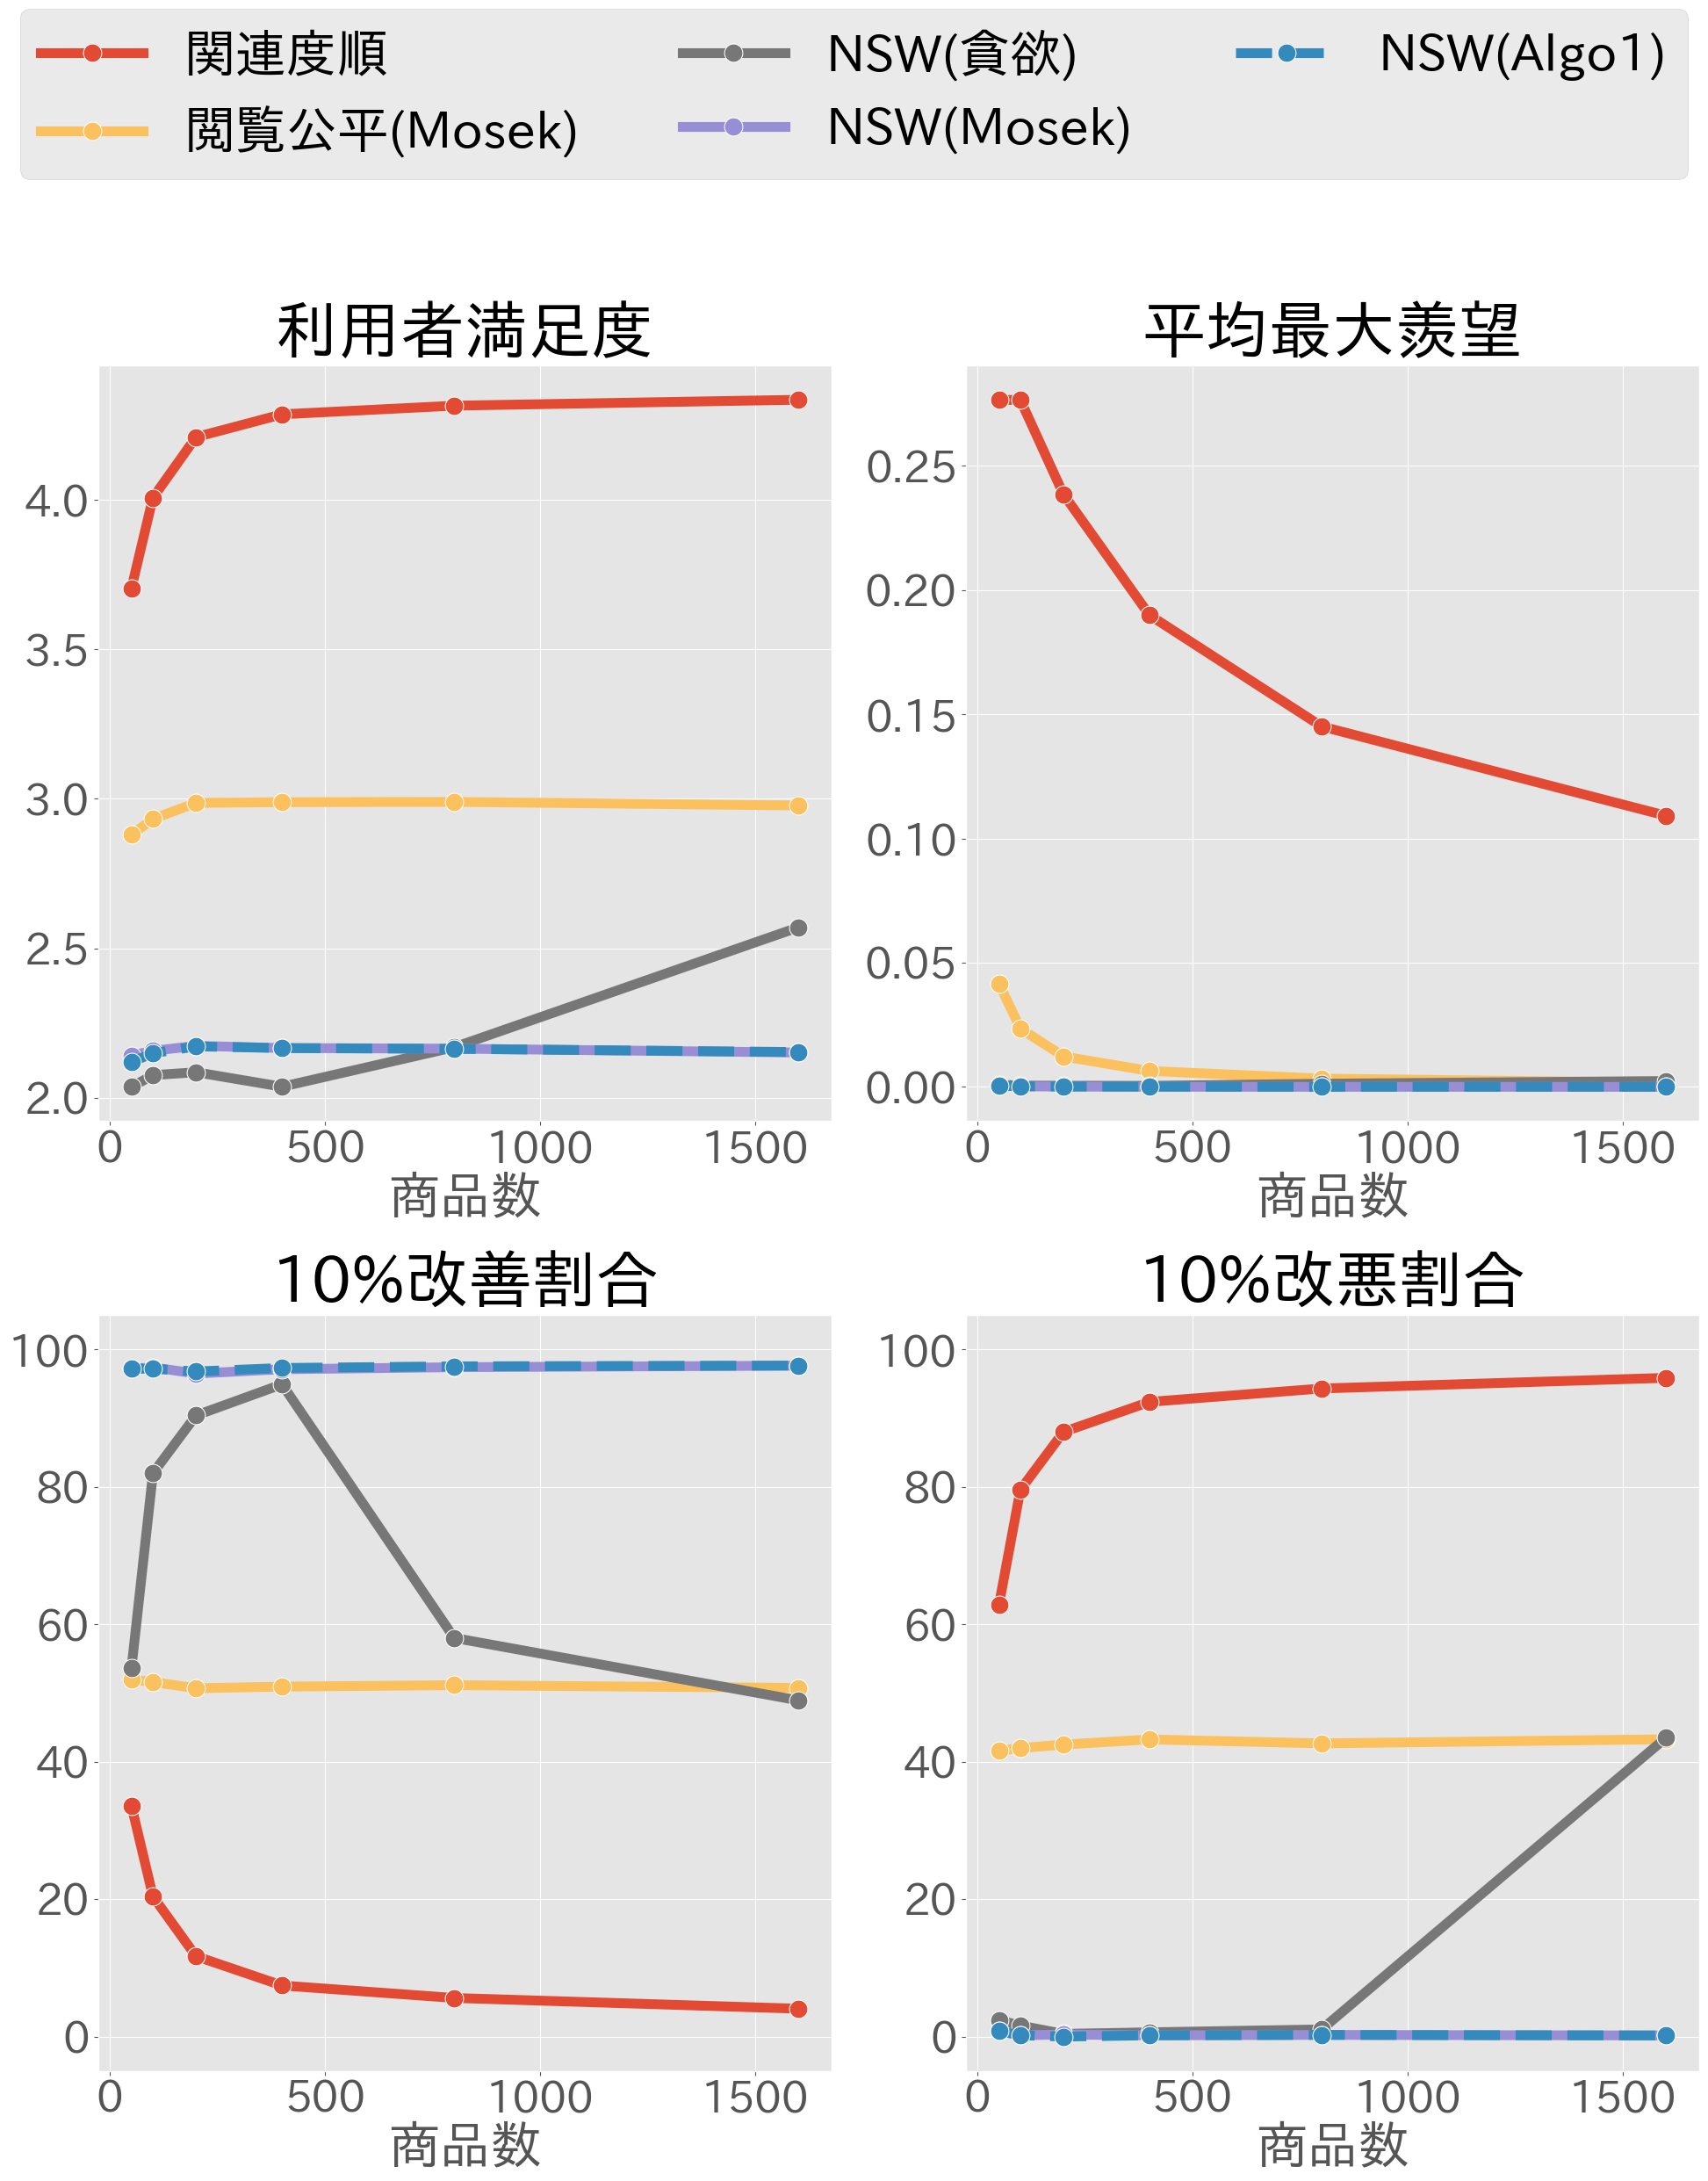

In [112]:
fig = plot_fairness_and_user_utils(
    varying_item_size_result, x="generator_params_n_doc", xlabel="商品数"
)
fig.savefig(OUTPUT_DIR / "artificial_data_eval_item.eps", bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


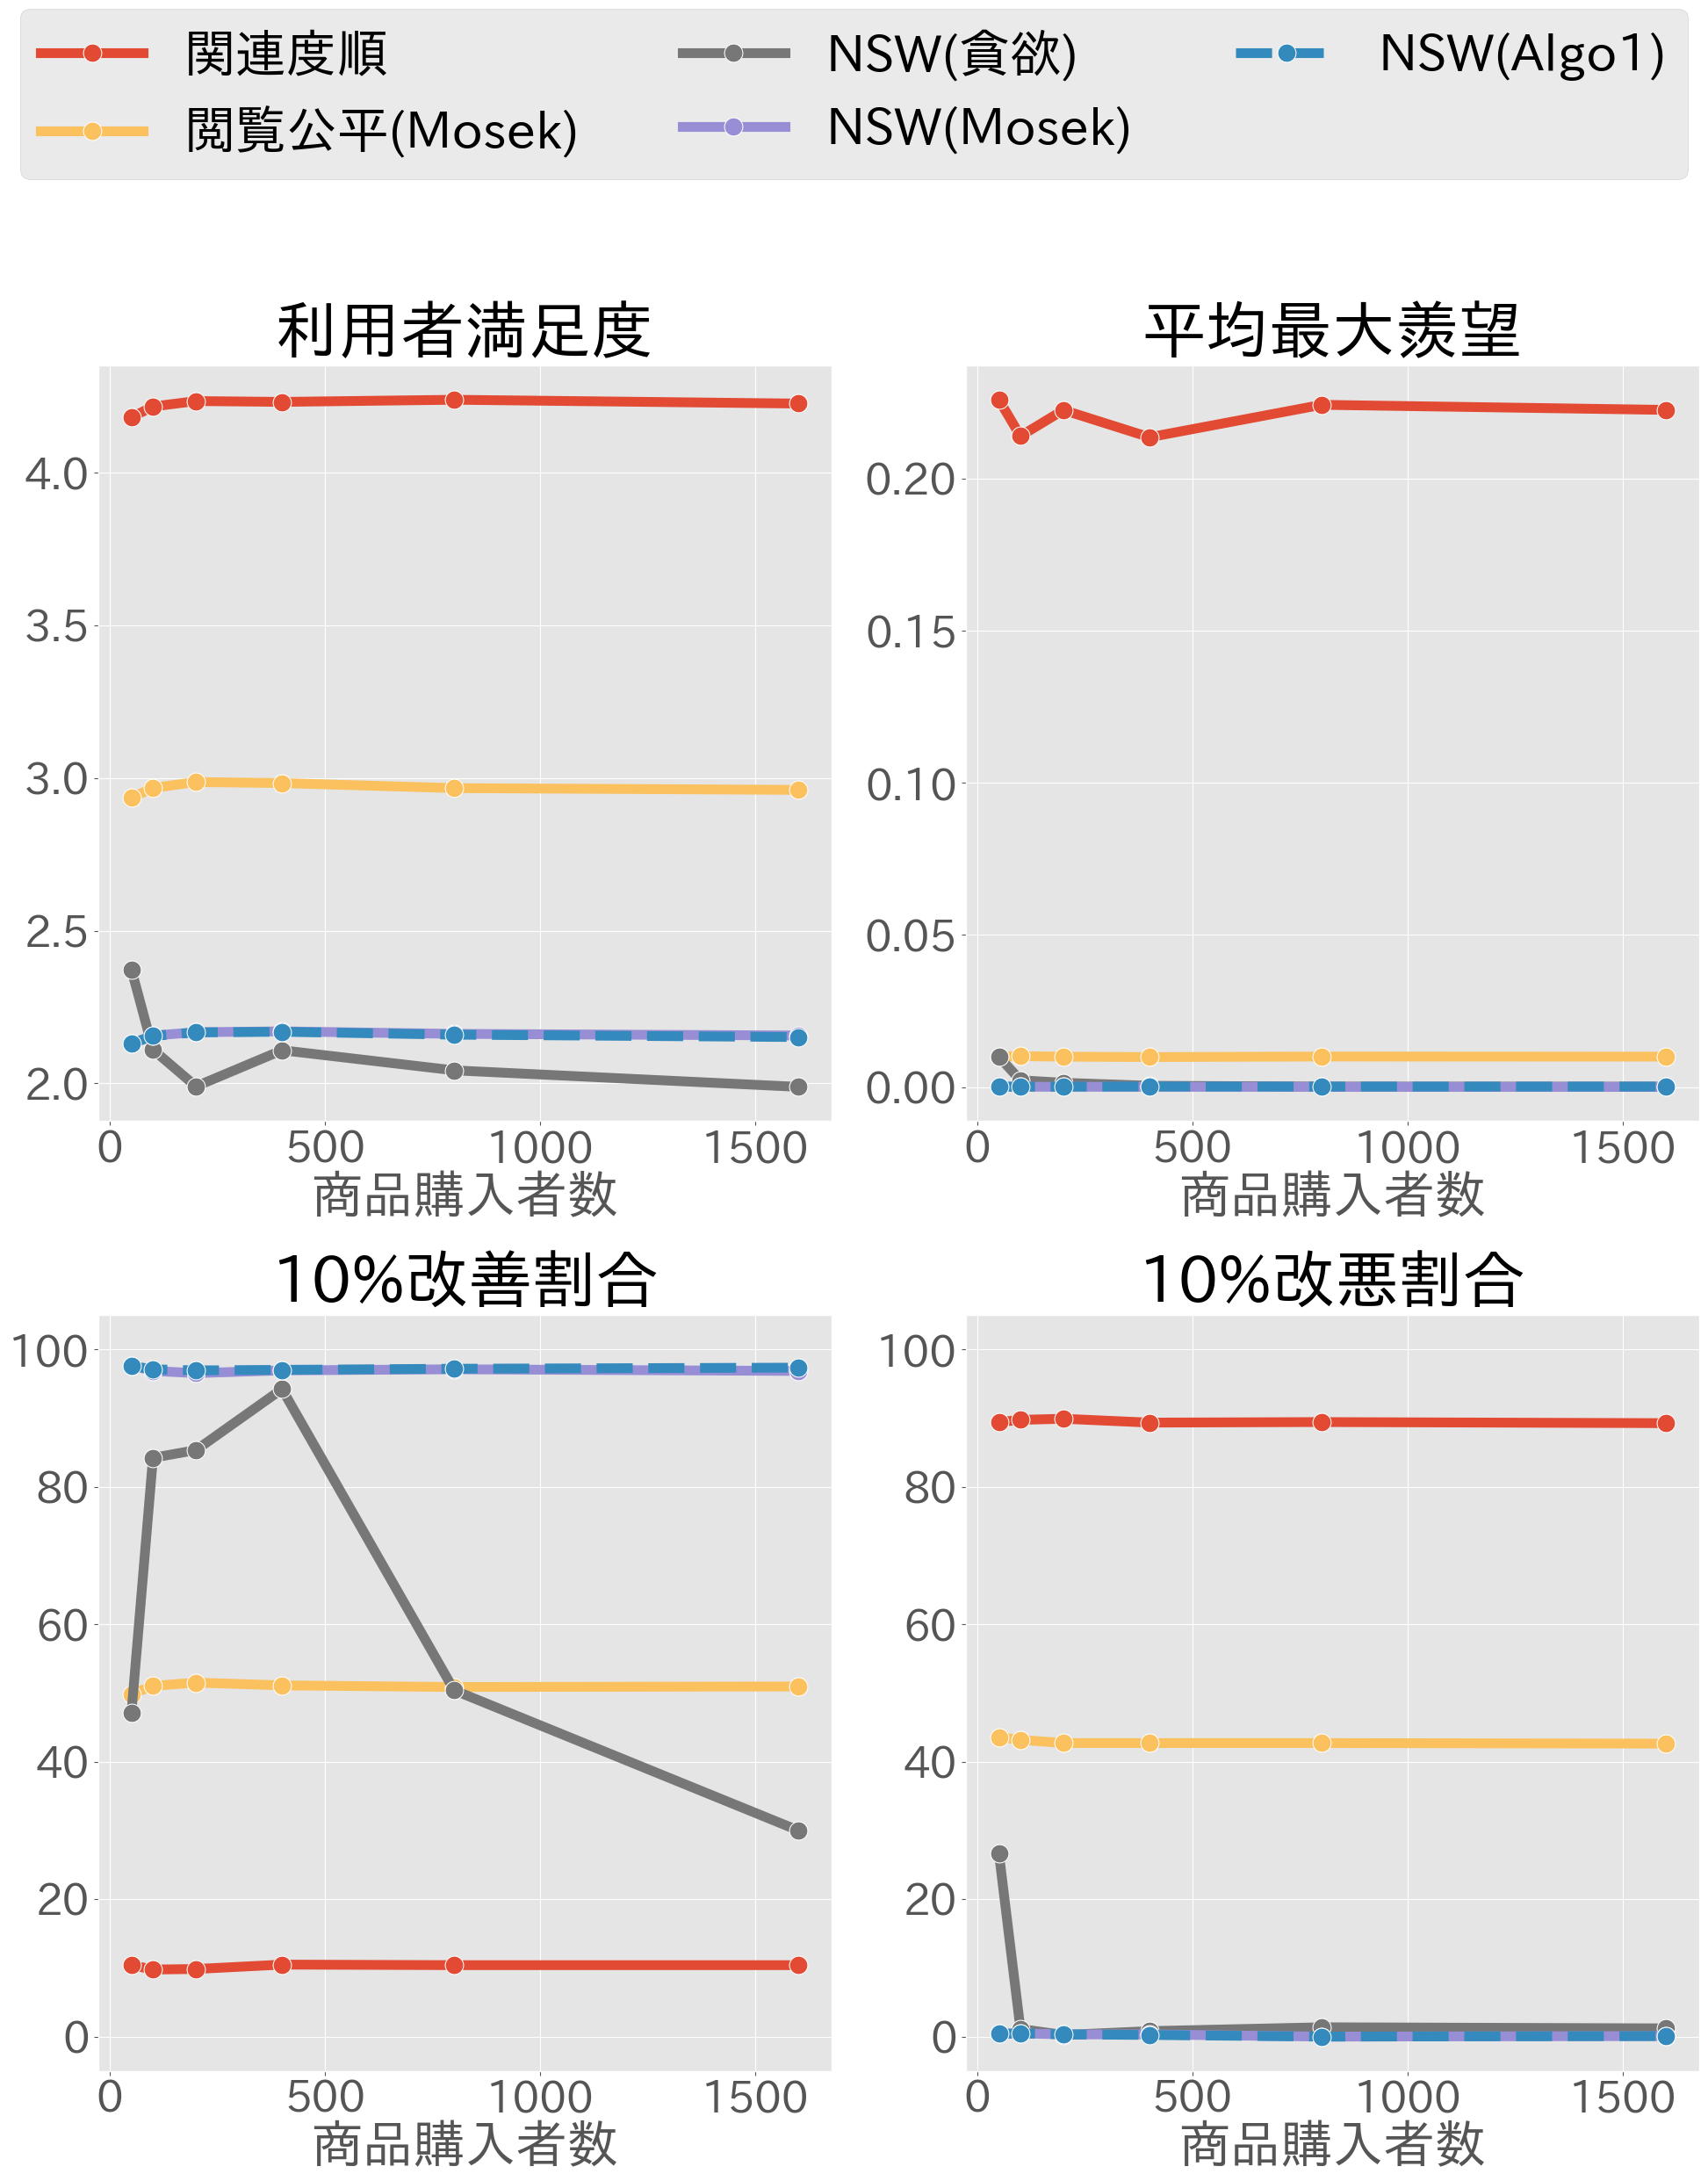

In [113]:
fig = plot_fairness_and_user_utils(
    varying_user_size_result, x="generator_params_n_query", xlabel="商品購入者数"
)
fig.savefig(OUTPUT_DIR / "artificial_data_eval_user.eps", bbox_inches="tight")

## クラスタ数を変化させたときの実験

IndexError: list index out of range

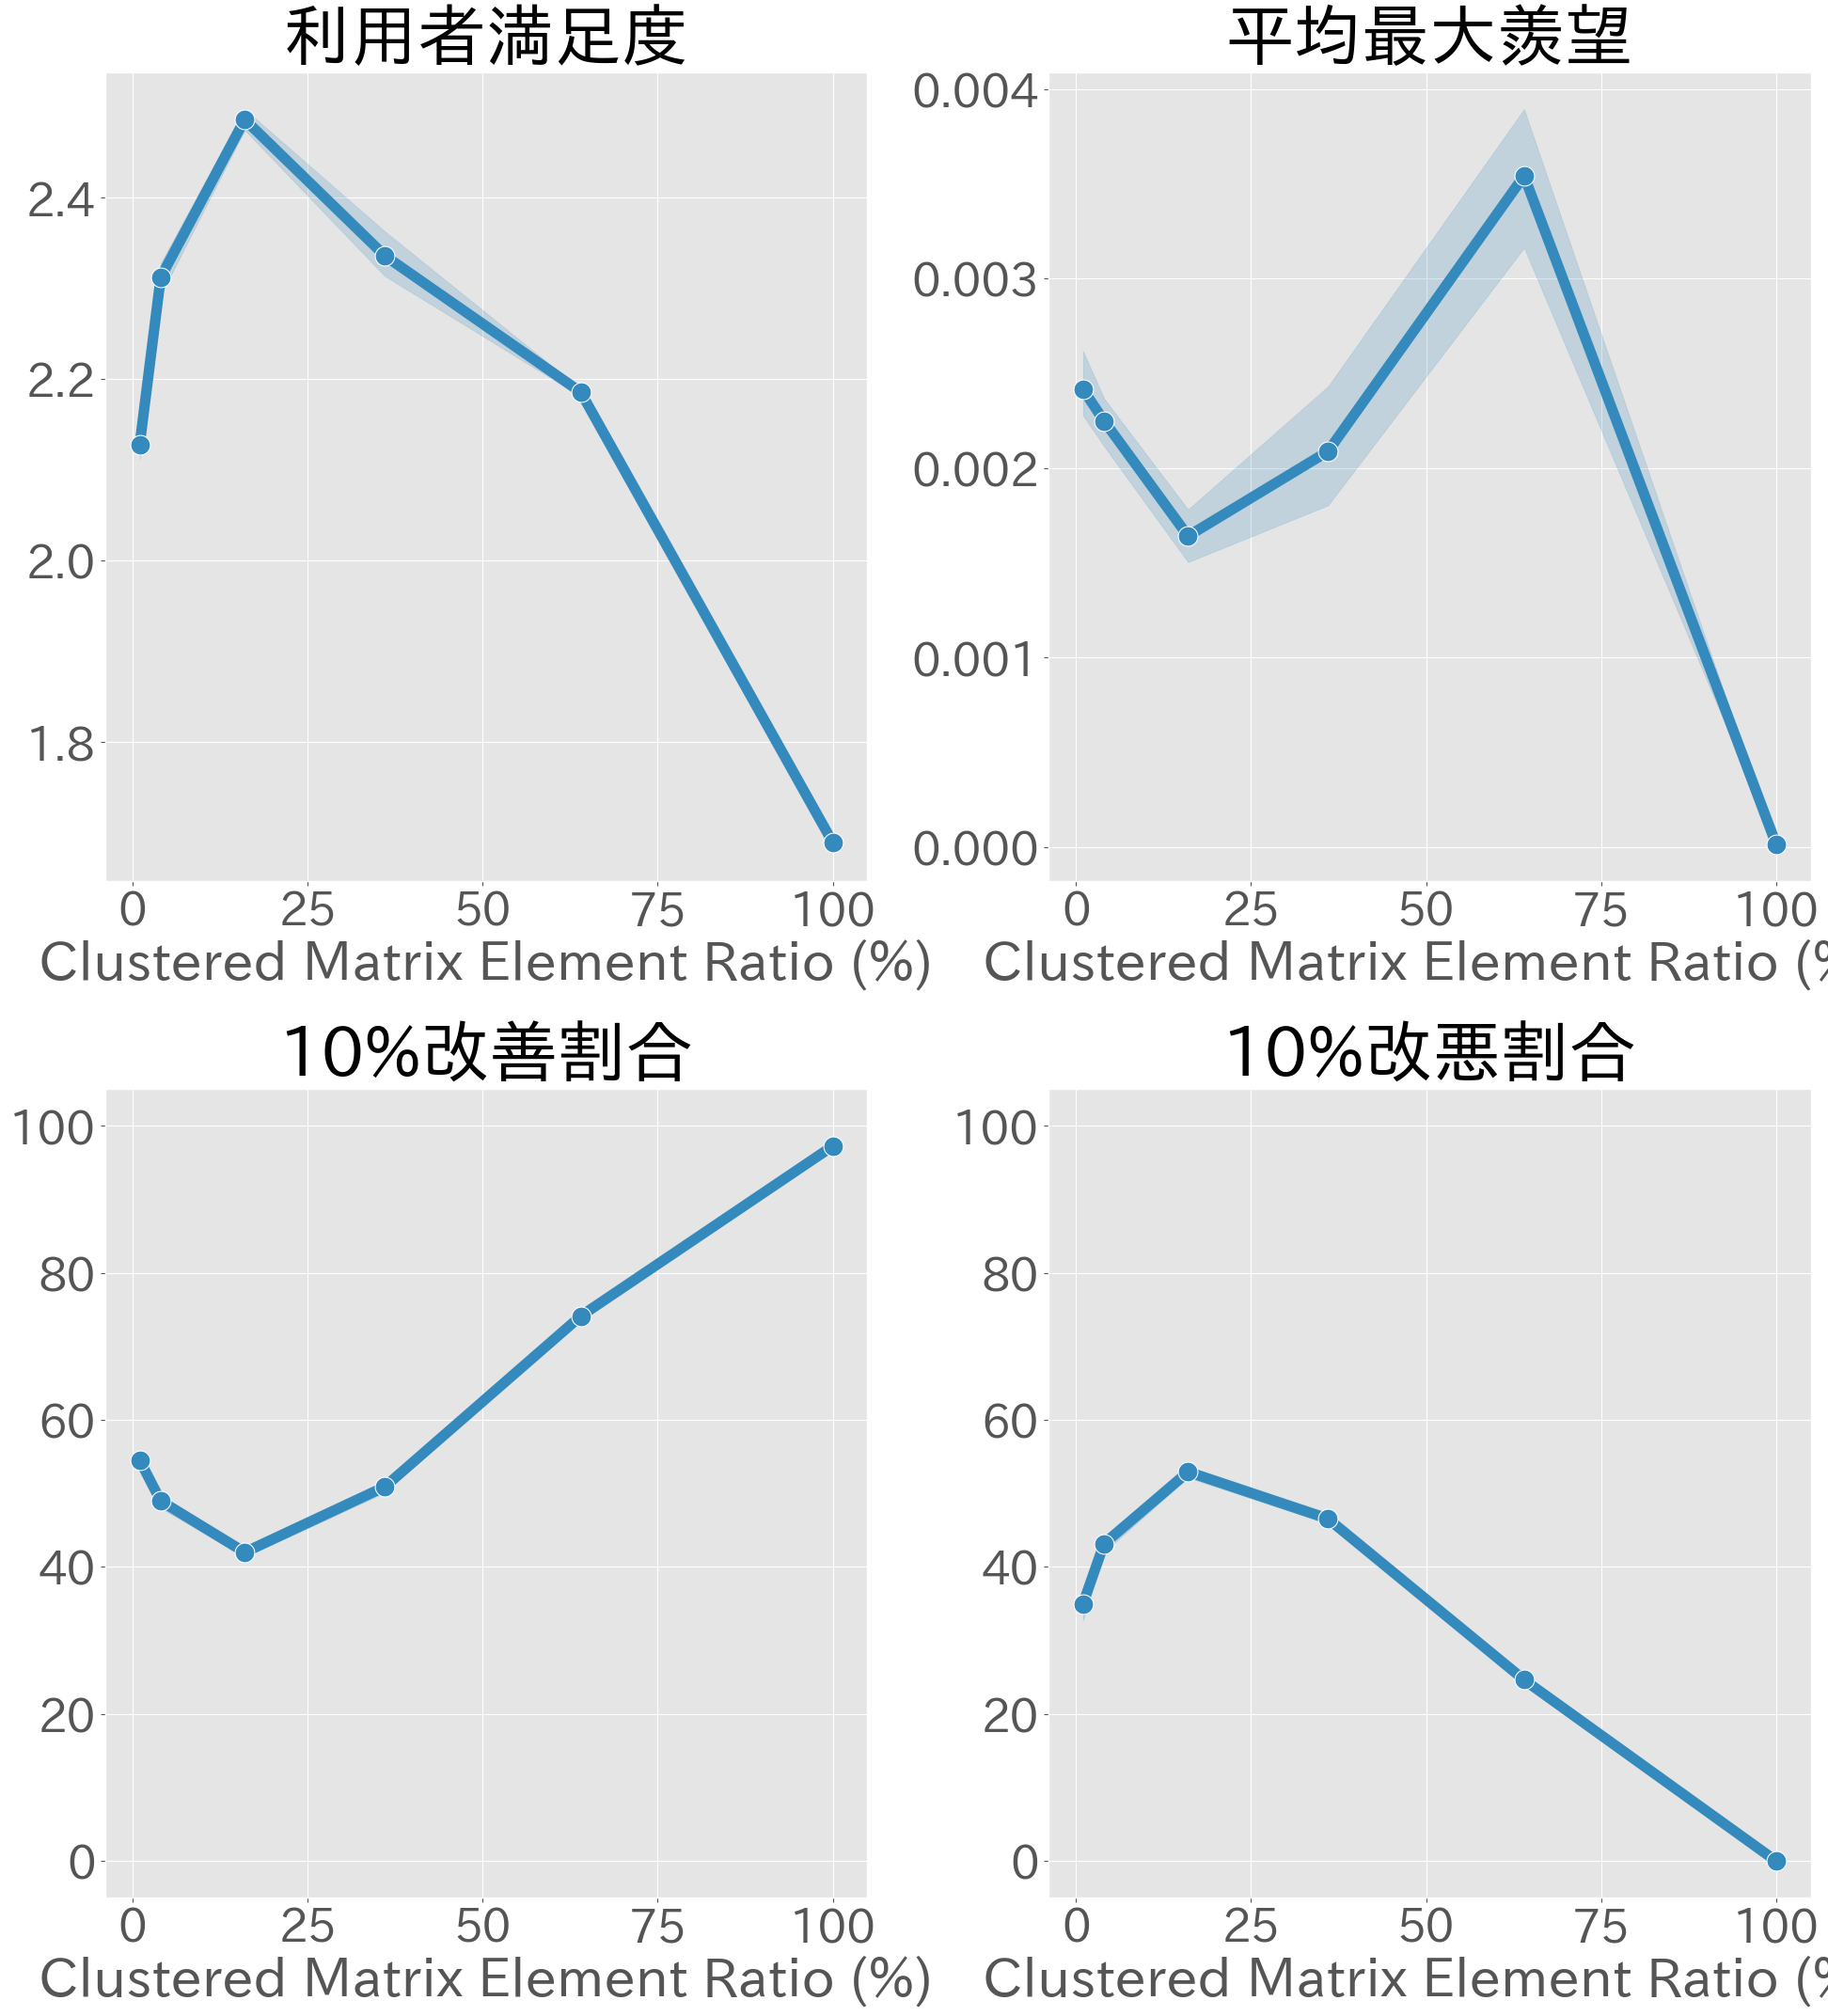

In [114]:
plot_fairness_and_user_utils(
    varying_cluster_size_result,
    x="n_params",
    xlabel="Clustered Matrix Element Ratio (%)",
    legend=False,
    errorbar=("ci", 95),
    metrics=[
        "user_util",
        "mean_max_envy",
        "pct_item_util_better",
        "pct_item_util_worse",
        "exec_time",
    ],
)

### クラスタ数とデータ数を変化させたときの実験

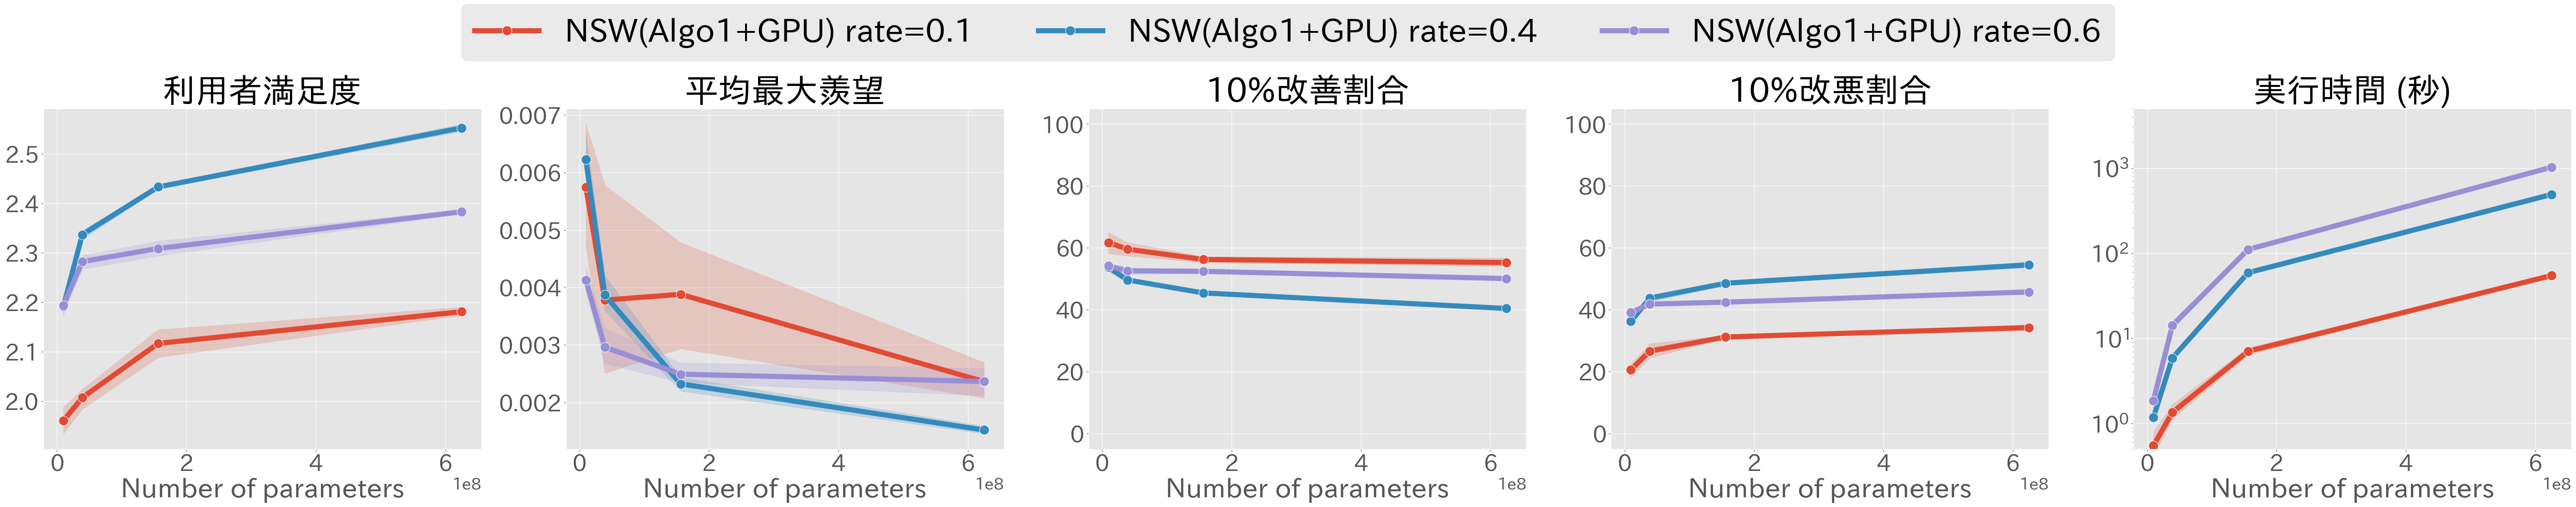

In [ ]:
varying_cluster_data_size_result = pd.read_csv(RESULT_PATH)
varying_cluster_data_size_result = varying_cluster_data_size_result.query(
    "exp_name == 'exp_cluster_datasize'"
).reset_index(drop=True)
varying_cluster_data_size_result["datasize"] = (
    varying_cluster_data_size_result["generator_params_n_doc"]
    * varying_cluster_data_size_result["generator_params_n_query"]
    * varying_cluster_data_size_result["generator_K"]
)
varying_cluster_data_size_result["cluster_rate"] = (
    varying_cluster_data_size_result["optimizer_params_n_query_cluster"]
    / varying_cluster_data_size_result["generator_params_n_query"]
).round(1)
varying_cluster_data_size_result["method"] = varying_cluster_data_size_result[
    "cluster_rate"
].apply(lambda x: f"NSW(Algo1+GPU) rate={x}")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
methods = varying_cluster_data_size_result["method"].unique()
methods = sorted(methods, key=lambda x: float(x.split("=")[1]))

for i, method in enumerate(methods):
    METHOD_TO_COLOR[method] = colors[i]
    METHOD_TO_LINESTYLE[method] = "-"

plot_fairness_and_user_utils(
    varying_cluster_data_size_result,
    x="datasize",
    xlabel="Number of parameters",
    legend=True,
    errorbar=("ci", 95),
    metrics=[
        "user_util",
        "mean_max_envy",
        "pct_item_util_better",
        "pct_item_util_worse",
        "exec_time",
    ],
)

## 実行時間

In [ ]:
def plot_exec_time(
    result: pd.DataFrame,
    x: str,
    xlabel: str,
    legend: bool = True,
    figsize: tuple[int, int] = (14, 10),
    ax: Optional[plt.Axes] = None,
):
    unique_method = result["method"].unique().tolist()
    order = [method for method in METHOD_TO_COLOR.keys() if method in unique_method]

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    for j, method in enumerate(order):
        color = METHOD_TO_COLOR[method]
        sns.lineplot(
            result.query("method == @method"),
            x=x,
            y="exec_time",
            ax=ax,
            marker="o",
            markersize=15,
            markers=True,
            linewidth=8,
            linestyle=METHOD_TO_LINESTYLE[method],
            legend=True,
            color=color,
            hue="method",
            palette=[color],
            errorbar=None,
        )
    ax.set_ylabel(METRICS_MAP["exec_time"], fontsize=40)
    ax.set_xlabel(xlabel, fontsize=40)
    ax.set_yscale("log")
    ax.set_ylim(bottom=1e-3, top=3e3)
    ax.tick_params(axis="both", labelsize=30)

    if legend:
        handles, legend = ax.get_legend_handles_labels()
        ax.legend(
            handles,
            legend,
            loc="upper center",
            ncol=3,
            bbox_to_anchor=(0.5, 1.20),
        )
    else:
        ax.get_legend().remove()

    if ax is None:
        fig.tight_layout()

    return ax


def plot_only_legend(ncol: int = 4, methods: list[str] = METHOD_TO_COLOR.keys()):
    fig, ax = plt.subplots(figsize=(14, 10))
    for method in methods:
        ax.plot([], [], label=method, color=METHOD_TO_COLOR[method], linewidth=8)
    ax.legend(
        loc="upper center",
        ncol=ncol,
        bbox_to_anchor=(0.5, 1.20),
        fontsize=40,
    )
    ax.axis("off")

In [ ]:
ideal_method = "NSW(Mosek)"
varying_item_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_item"],
    on=["generator_params_n_doc", "seed"],
    ideal_method=ideal_method,
    ignore_methods=["pgd_nsw"],
    consider_solver=True,
    consider_device=True,
)
display(varying_item_size_result.head(5))

varying_user_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_user"],
    on=["generator_params_n_query", "seed"],
    ideal_method=ideal_method,
    ignore_methods=["pgd_nsw"],
    consider_solver=True,
    consider_device=True,
)
display(varying_user_size_result.head(5))

,number_of_nan
exec_time_rate,21
exec_time,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_params_n_doc,seed,method,exec_time_rate,exec_time,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_rate_nsw,exec_time_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1600,4,NSW(Algo1+GPU),0.000111,0.122731,2.560889,0.002382,48.8750,42.5625,NaN,1108.811406,2.146756,0.000014,97.7500,0.25
1,1600,4,NSW(貪欲),0.000120,0.133038,2.560889,0.002382,48.8750,42.5625,NaN,1108.811406,2.146756,0.000014,97.7500,0.25
2,1600,1,NSW(Algo1+GPU),0.000104,0.124772,2.584863,0.002368,48.9375,44.8125,NaN,1205.428054,2.158890,0.000014,97.6250,0.25
3,1600,1,NSW(貪欲),0.000104,0.124878,2.584863,0.002368,48.9375,44.8125,NaN,1205.428054,2.158890,0.000014,97.6250,0.25
4,1600,0,NSW(Algo1+GPU),0.000108,0.123640,2.564897,0.002377,49.0000,43.0625,NaN,1147.260273,2.148788,0.000015,97.5625,0.00


,number_of_nan
exec_time_rate,0
exec_time,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_params_n_query,seed,method,exec_time_rate,exec_time,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_rate_nsw,exec_time_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1600.0,0,NSW(Algo1+GPU),0.001543,0.454402,1.988474,0.000131,30.0,1.2,NaN,294.552099,2.139198,0.000074,97.2,0.0
1,1600.0,0,NSW(貪欲),0.001539,0.453454,1.988474,0.000131,30.0,1.2,NaN,294.552099,2.139198,0.000074,97.2,0.0
2,800.0,4,NSW(Algo1+GPU),0.001600,0.228102,2.014424,0.000168,44.0,1.2,NaN,142.555053,2.140957,0.000077,98.0,0.0
3,800.0,4,NSW(貪欲),0.001628,0.232024,2.014424,0.000168,44.0,1.2,NaN,142.555053,2.140957,0.000077,98.0,0.0
4,800.0,3,NSW(Algo1+GPU),0.001462,0.229242,2.066056,0.000165,61.6,0.8,NaN,156.846717,2.183437,0.000071,96.8,0.0


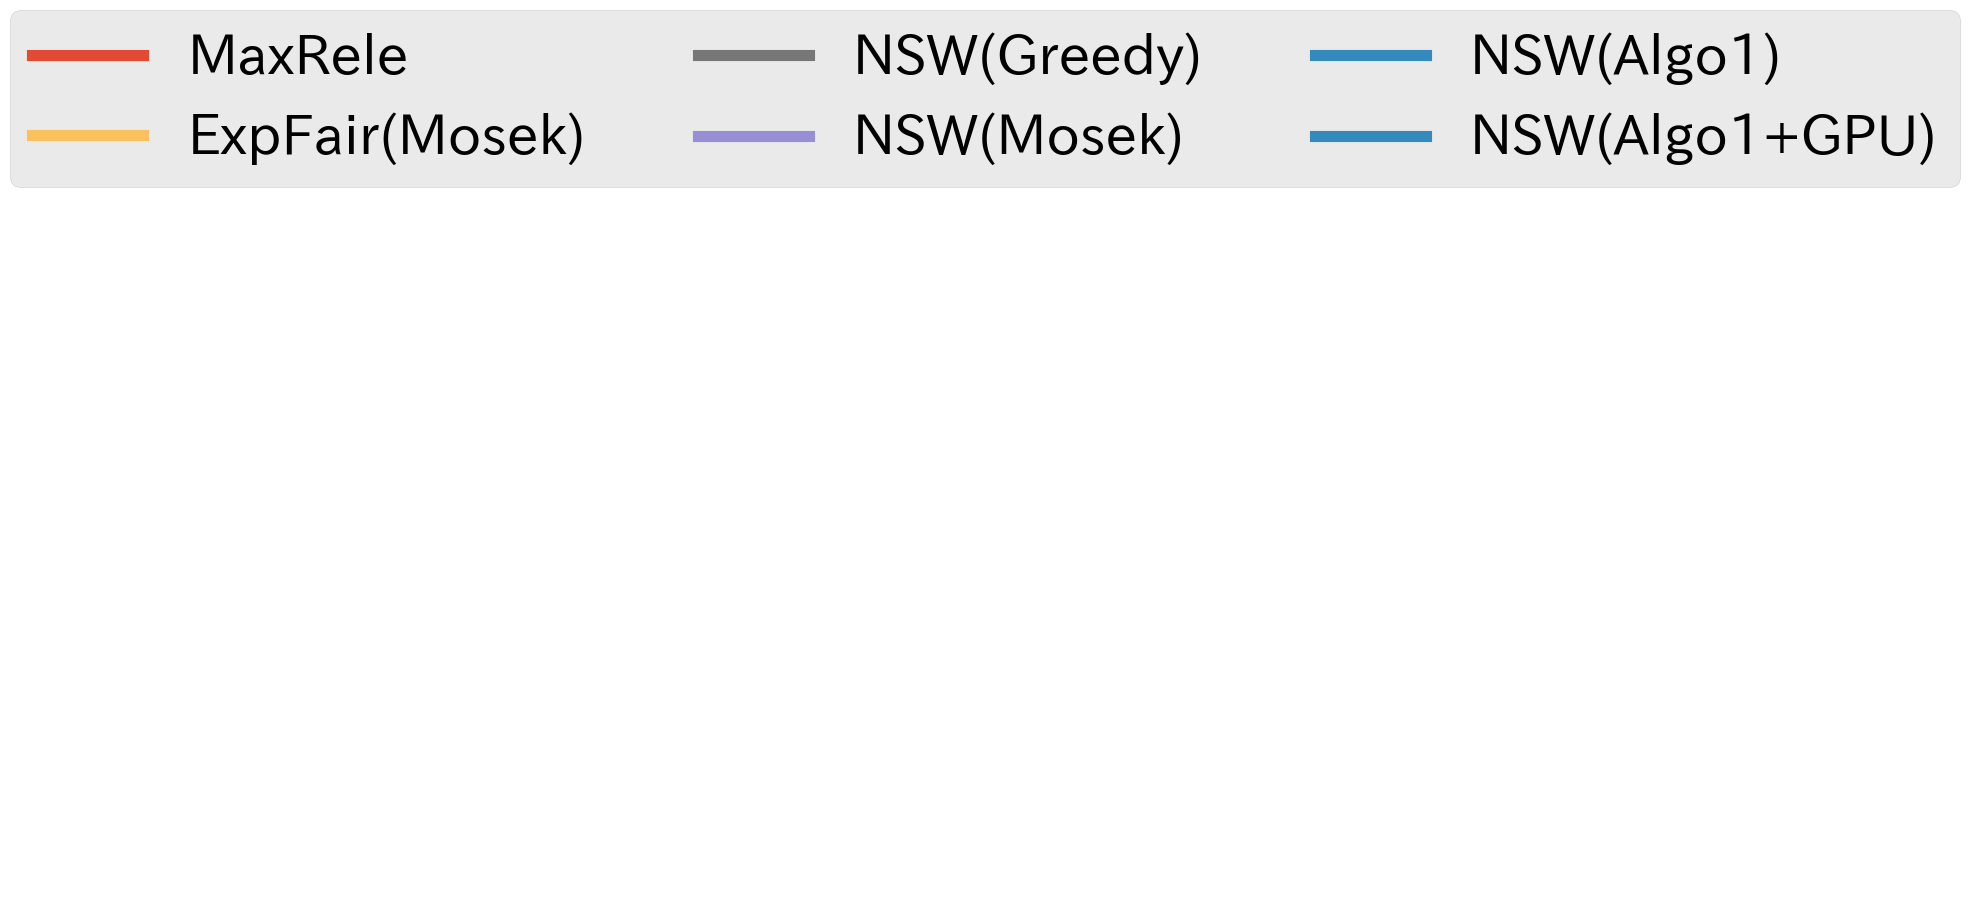

In [ ]:
plot_only_legend(
    ncol=3,
    methods=[
        "MaxRele",
        "ExpFair(Mosek)",
        "NSW(Greedy)",
        "NSW(Mosek)",
        "NSW(Algo1)",
        "NSW(Algo1+GPU)",
    ],
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


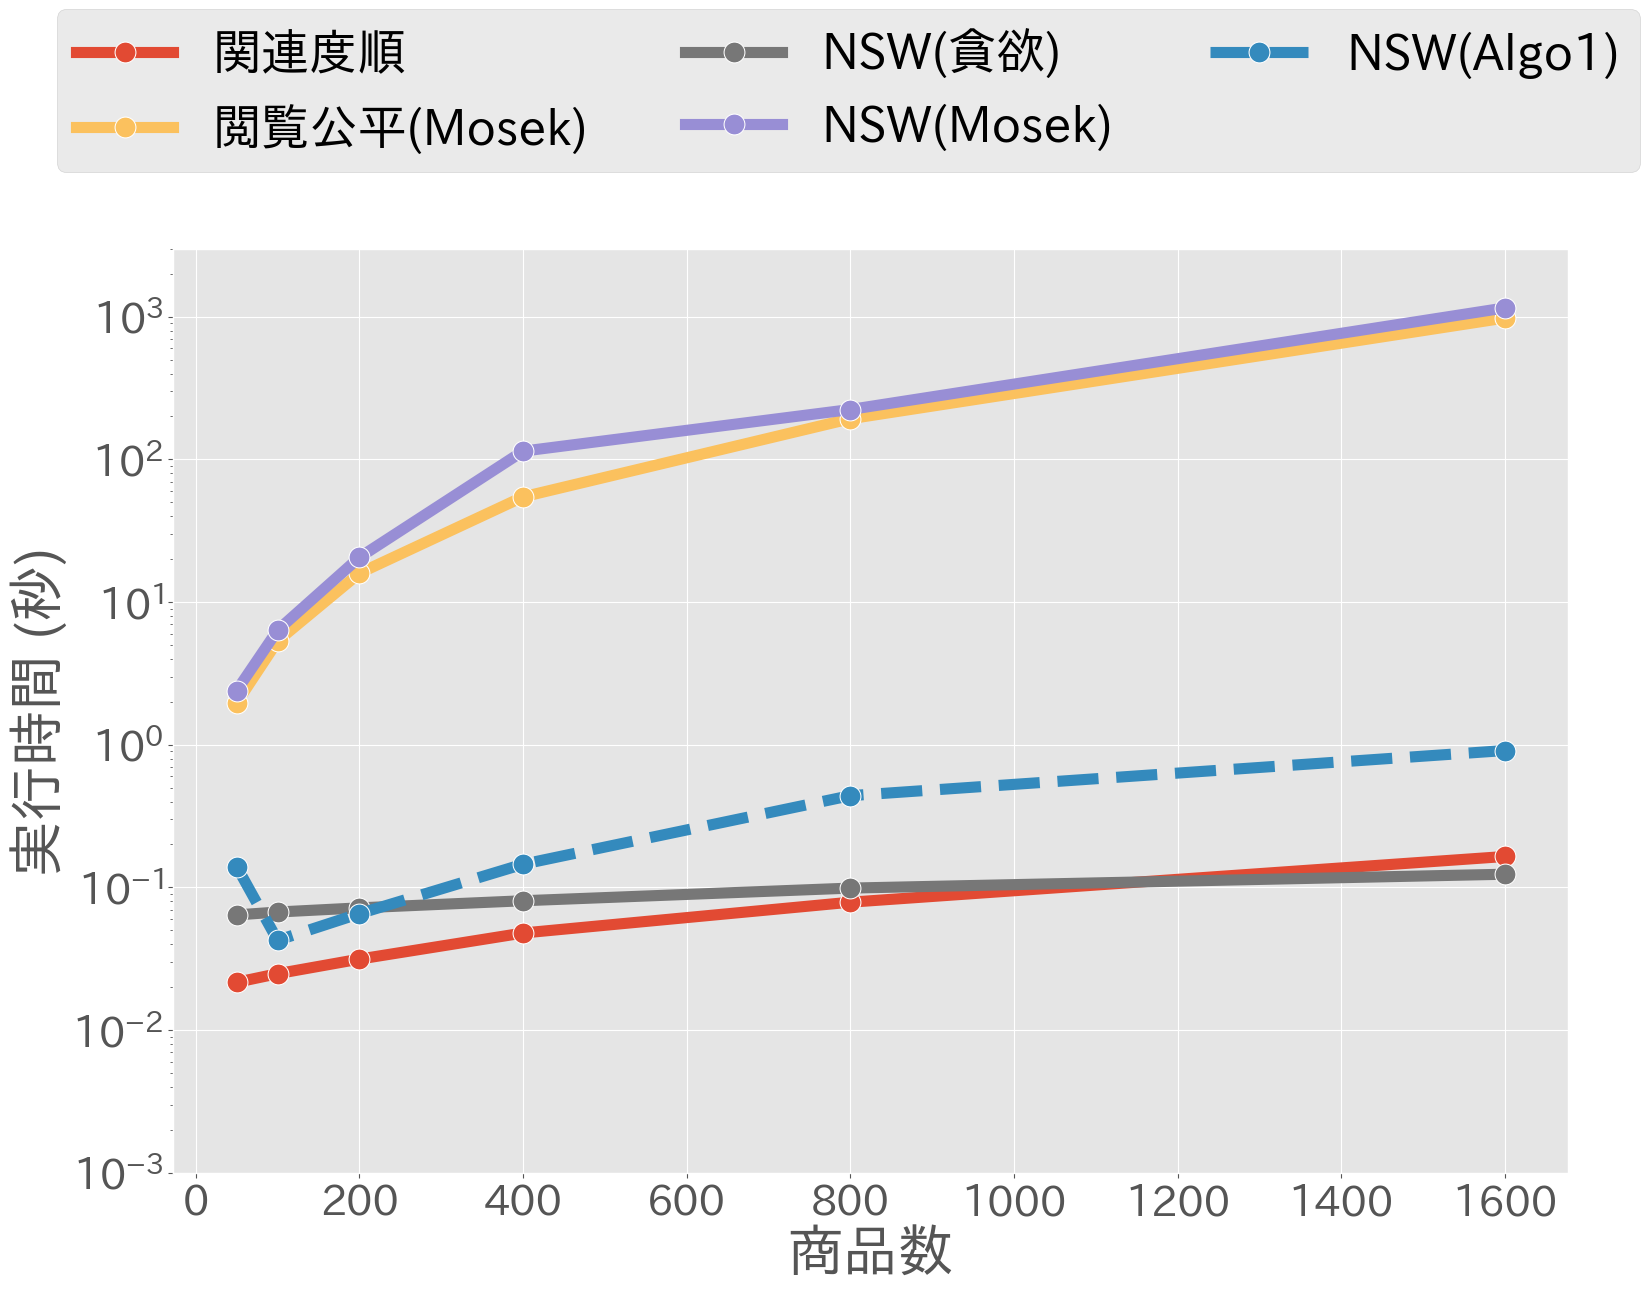

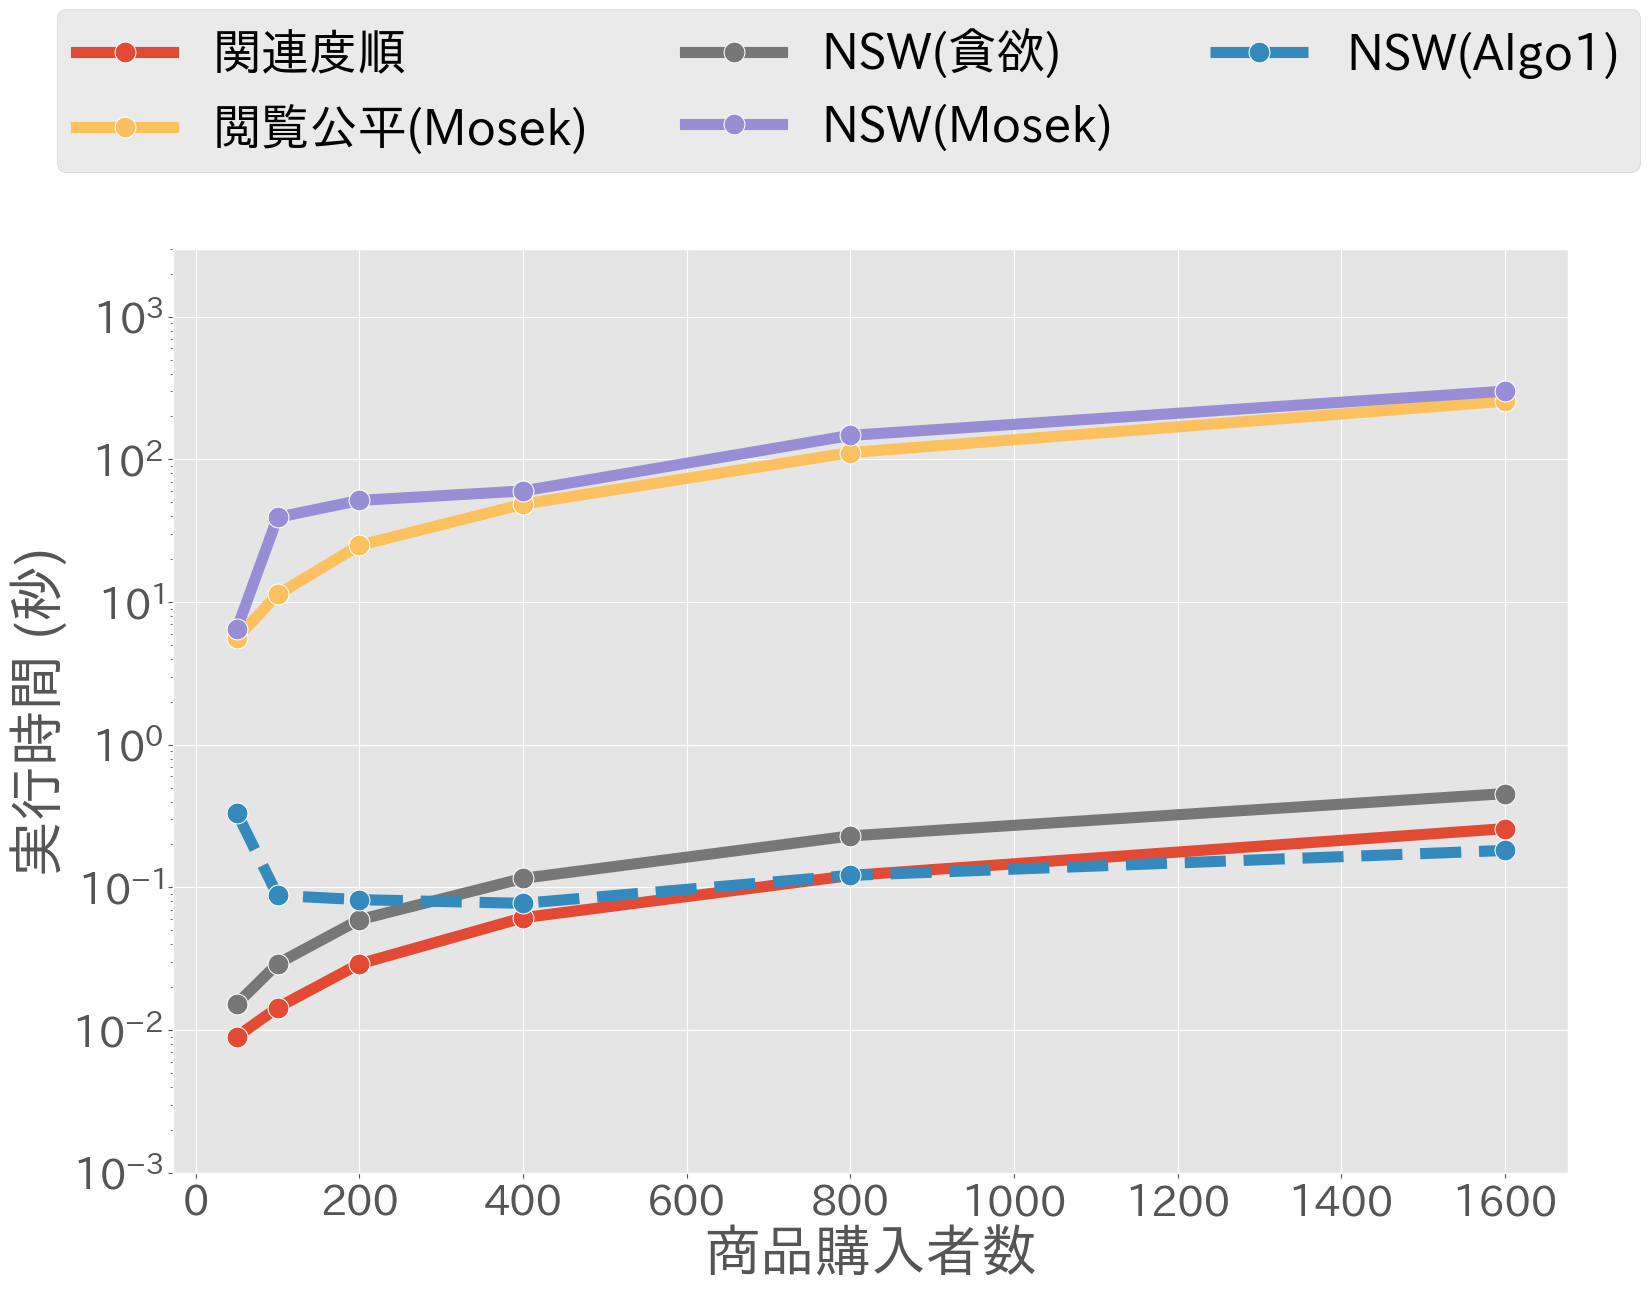

In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(18 * 2, 12))

fig, axes = plt.subplots(1, 1, figsize=(18, 12))
plot_exec_time(
    varying_item_size_result,
    x="generator_params_n_doc",
    xlabel="商品数",
    legend=True,
    ax=axes,
)
handles, legend = axes.get_legend_handles_labels()
axes.get_legend().remove()
fig.legend(
    handles,
    legend,
    fontsize=35,
    bbox_to_anchor=(0.5, 1.10),
    ncol=3,
    loc="upper center",
)
fig.savefig(OUTPUT_DIR / "exec_time_item.eps", bbox_inches="tight")

fig, axes = plt.subplots(1, 1, figsize=(18, 12))
plot_exec_time(
    varying_user_size_result,
    x="generator_params_n_query",
    xlabel="商品購入者数",
    ax=axes,
    legend=True,
)
handles, legend = axes.get_legend_handles_labels()
axes.get_legend().remove()
fig.legend(
    handles,
    legend,
    fontsize=35,
    bbox_to_anchor=(0.5, 1.10),
    ncol=3,
    loc="upper center",
)
fig.savefig(OUTPUT_DIR / "exec_time_user.eps", bbox_inches="tight")

# legend
# handles, legend = axes[0].get_legend_handles_labels()
# axes[0].get_legend().remove()
# fig.legend(
#     handles,
#     legend,
#     fontsize=40,
#     bbox_to_anchor=(0.5, 1.10),
#     ncol=6,
#     loc="upper center",
# )

# fig.tight_layout()

<Axes: xlabel='Clustered Matrix Element Ratio (%)', ylabel='実行時間 (秒)'>

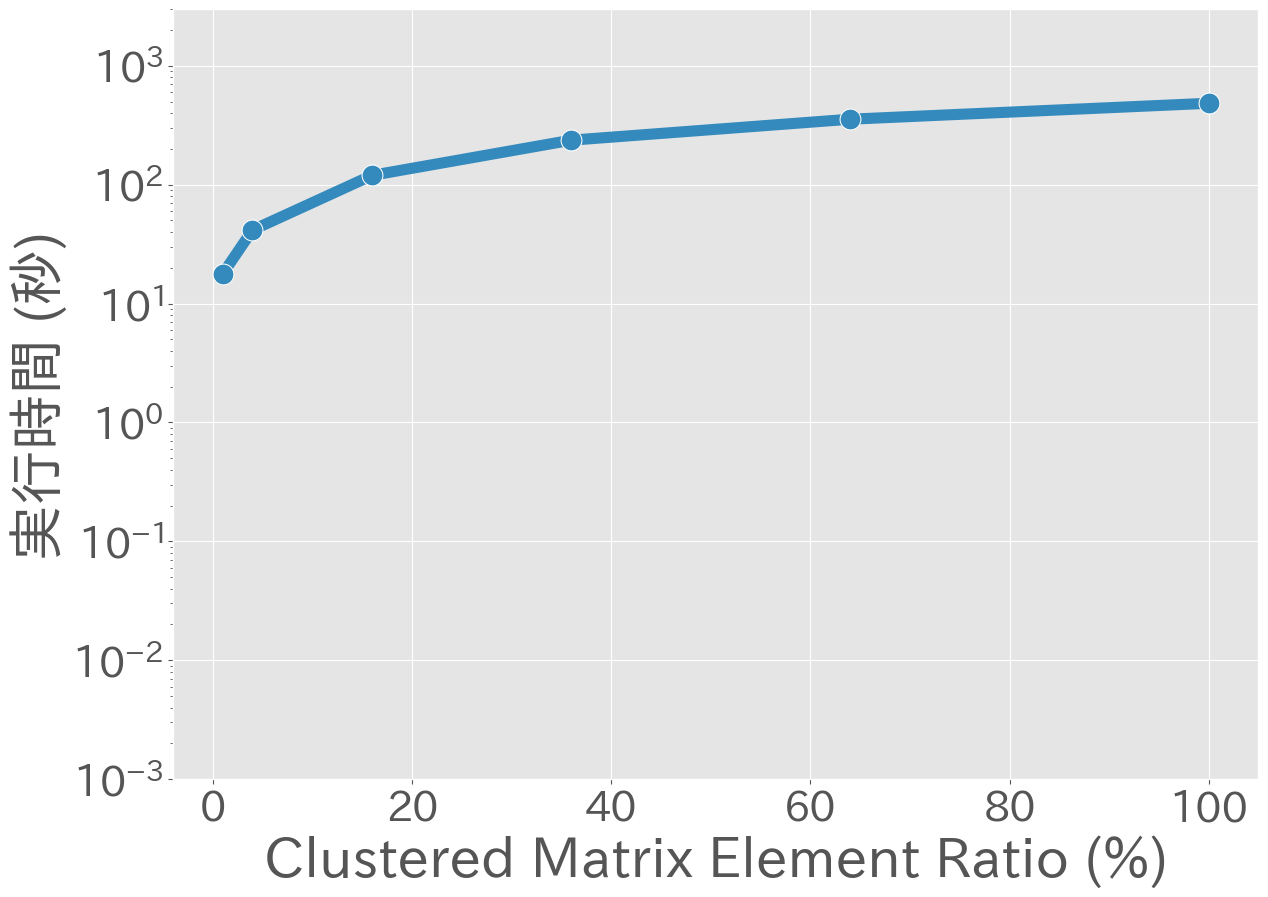

In [ ]:
plot_exec_time(
    varying_cluster_size_result,
    x="n_params",
    xlabel="Clustered Matrix Element Ratio (%)",
    legend=False,
)